<a href="https://colab.research.google.com/github/minzsiure/Variable-Binding-Capacity/blob/main/Assembly_Recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Helper Functions** 

### Quick note on the model ###
**formula CAPk(W_xy_t @ x + W_yy_t @ y_t) = y_{t+1}**

*   ##### **W_xy_t:** connections bw assembly x and y at time t; entry[i,j] = 1 represents a connection bw x_j and y_i; the entry is in {0, 1}, with probability p of intializing to 1, thus probability (1-p) intialiing to 0.
*   ##### **W_yy_t:** connections within assembly y among its k neurons at time t; entry[i,j] represents connection between y_i and y_j where dim(W_xy_t) = n by n, dim(x) = n by 1
*   ##### **dim (W_yy_t)** = n by n, dim(y_t) = n by 1
*   ##### **dim (y_{t+1})** = n by 1 (due to capping k, only k nonzero entries)
*   ##### cap/inhibition -> plasticity

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from tqdm import tqdm
from scipy.spatial.distance import hamming
rng = np.random.default_rng()

**Initalization Function**

In [3]:
def randBin(M,N,p):
    """
    initalize an M by N matrix, with each entry being 1 with a probability
    of p and being 0 otherwise
    """
    return np.random.choice([0., 1.], size=(M,N), p=[1-p, p])

**Plasticity**

In [4]:
def enhance(W_t, y, x, Beta, n):
    """
    multiply W[i,j] by (1+Beta) if y_i(t) = 1, x_j = 1
    keep W[i,j] otherwise
    
    return W_{t+1}
    """
    for i in range(0, n):
        for j in range(0, n):
            if y[i] == 1 and x[j] == 1:
                W_t[i][j] *= (Beta+1)
    return W_t

**Inhibition (CAPk)**

In [5]:
def CAPk(z,k):
    """
    Given a n-dim vector z, its k largest numbers are set to 1. 
    The rest of n-k entries are set to 0.
    """
    if len(np.where(z != 0)[0]) > k:
        index = np.argsort(z)
        z[index[:-k]] = 0
    z[np.where(z != 0.)[0]] = 1.
    return z

### Helper Functions for Stream of Stimuli

In [6]:
def hebbian_update(W, out_vec, in_vec, beta):
    for i in np.where(out_vec!=0.)[0]:
        for j in np.where(in_vec!=0.)[0]:
            W[i,j] *= 1. + beta
    return W

def capk(vec, k):
    if len(np.where(vec!=0.)[0]) > k:
        indices = np.argsort(vec)
        vec[indices[:-k]] = 0.
    vec[np.where(vec!=0.)[0]] = 1.0
    return vec

In [7]:
def generate_stimulus(n, k, p_r, coreset=None):
    if coreset is None:
        coreset = np.arange(k)
        
    non_coreset = np.array([i for i in range(n) if i not in coreset])
    
    stim_idx = np.concatenate((np.random.choice(coreset, np.floor(p_r*k).astype(np.int32), replace=False), 
                               np.random.choice(non_coreset, k - np.floor(p_r*k).astype(np.int32), replace=False)))
    x = np.zeros(n)
    x[stim_idx] = 1.0
    
    return x

# **A) Assembly Recall: Behavior of Hamming Distance Between Input and Output in Projection Recovery with Noisy Stimulus**

Denote y_0 = project(x_0), and assembly created with stimulus input x_0
*   Do project with and without recurrence
*   Try T = 2 and T = 5 steps of random projection and cap
*   Goal 1: Plot the hamming distance d_H_in(x,x_0) VS d_H_out(y,y_0) between 0 and 2k
  *   x: input used to recover assembly
  *   x_0: input used to create assembly
  *   y: recovered assembly
  *   y_0: original assembly
*   Goal 2: Find the smallest T such that both d_H_in and d_H_out are both 0 









### Helper functions

In [8]:
def create_recovery_input(ham_dis, input):
  '''
  a helper function for creating inputs with _ham_dis_ different entries
  '''
  #1. first, identify set of indices with entry = 1 and index with entry = 0
  output = copy.deepcopy(input)
  entry_1 = []
  entry_0 = []
  for i in range(len(output)):
    if input[i] == 1.0: #if entry i is 1
      entry_1.append(i)
    else: #if entry i is 0
      entry_0.append(i)
  #2. randomly select _ham_dis_ of entry_1 to omit into 0, and _ham_dis of entry_0 to turn into 1
  if ham_dis%2==0: #entry is even
    UpdatedEntry1 = random.sample(entry_1, ham_dis//2)
    UpdatedEntry0 = random.sample(entry_0, ham_dis//2) 

  # omit
  for j in UpdatedEntry1:
    output[j] = 0.0
  for z in UpdatedEntry0:
    output[z] = 1.0

  return output

In [9]:
#test case 
n=20
k=2
ham_dis = 2
x_0 = np.zeros(n)
stim = np.random.permutation(n)[:k]
x_0[stim] = 1.0
print('old',x_0)
x_hm = create_recovery_input(ham_dis,x_0)
print('new',x_hm)
print(hamming(x_0, x_hm)*len(x_0))

old [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
new [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
2.0


### Executive functions

In [10]:
def recover_proj_hamDist_init(n,p,k,Beta):
    """
    Initialize weights, x, and y.
    """
    #1. init x_0, y_0, Ws
    x_0 = np.zeros(n)
    stim = np.random.permutation(n)[:k]
    x_0[stim] = 1.0
    y_0 = np.zeros((n))
    W_xy = randBin(n,n,p)
    W_yy = randBin(n,n,p)
    
    #initialize new x and new y for recovering usage
    x = np.zeros(n)
    stim_x = np.random.permutation(n)[:k]
    x[stim_x] = 1.0
    y = np.zeros((n))
    
    #learned weights
    #use those weights to do the recovery
    return x,y,W_xy,W_yy

In [22]:
def recover_proj_hamDist_recovering(x,y,k,Beta,W_xy,W_yy,proj_time,sampling_time,recover_time,recur):
    W_xy_copy = copy.deepcopy(W_xy)
    x_copy = copy.deepcopy(x)
    if recur:
        W_yy_copy = copy.deepcopy(W_yy)
    y_copy = copy.deepcopy(y)
    #2. Fire/train for _time_ steps to get y_t
    print('Training starting...')
    for t in tqdm(range(proj_time)):
        if recur:
          y_t = W_xy_copy@x_copy+(W_yy_copy@y_copy)
        else:
          y_t = (W_xy_copy@x_copy)
        
        #inhibition
        y_t = CAPk(y_t,k)
        #plasticity
        W_xy_copy = enhance(W_xy_copy, y_t, x_copy, Beta, n)
        if recur:
          W_yy_copy = enhance(W_yy_copy, y_t, y_copy, Beta, n)

        y_copy = np.copy(y_t)

    #3. Try recover by measuring hamming distances d_H_out(y,y_0) and d_H_in(x,x_0)
    # d_H_in ranges from 0 to 2*k
    ham_dH_out_total = []
    ham_dH_in_total = []
    ham_range = [item for item in range(0, 2*(k+1), 2)]
    result = np.zeros((len(ham_range), sampling_time))

    for j, ham in enumerate(ham_range):
      print("Recovering for ham %i..."%(ham))
      avg_temp = [] #a holder for averaging over all samples
      for i in tqdm(range(sampling_time)):
        # for each ham_dist, generate a new x, and train recovery for proj_time many steps, then calculate hamming(y_0,y)
        y_copy_copy = copy.deepcopy(y_copy)
        x_copy_copy = create_recovery_input(ham,x_copy) #generate new x based on current ham_dist   
        
        for time in range(recover_time):
          # train for _recover_time steps
          if recur:
            y_t_recover = (W_xy_copy@x_copy_copy)+(W_yy_copy@y_copy_copy)
          else:
            y_t_recover = (W_xy_copy@x_copy_copy)
        
          # inhibition
          y_t_recover = CAPk(y_t_recover,k)

          y_copy_copy = np.copy(y_t_recover)
        avg_temp.append(hamming(y_copy_copy, y_copy)*n)

      result[j] = avg_temp
      ham_dH_out_total.append(sum(avg_temp)/len(avg_temp)) # take average
      avg_temp = []
      ham_dH_in_total.append(ham)
      print()

    # return ham_dH_in_total, ham_dH_out_total, None
    return ham_dH_in_total, np.mean(result, axis=1), np.std(result, axis=1)/np.sqrt(sampling_time)

In [23]:
rec = [False,True]
n, k, Beta, p =1000, 41, 0.05, 0.03
proj_time, recover_time, sampling_time = 40, 10, 10

size_in, size_out, size_sem = [], [],[]
x,y,W_xy,W_yy = recover_proj_hamDist_init(n,p,k,Beta)

for r in rec:
  ham_in, ham_out, sem = recover_proj_hamDist_recovering(x,y,k,Beta,W_xy,W_yy,proj_time,sampling_time,recover_time,r)
  size_in.append(ham_in)
  size_out.append(ham_out)
  size_sem.append(sem)

Training starting...


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


Recovering for ham 0...


100%|██████████| 10/10 [00:00<00:00, 163.89it/s]



Recovering for ham 2...


100%|██████████| 10/10 [00:00<00:00, 142.40it/s]



Recovering for ham 4...


100%|██████████| 10/10 [00:00<00:00, 137.66it/s]



Recovering for ham 6...


100%|██████████| 10/10 [00:00<00:00, 144.52it/s]



Recovering for ham 8...


100%|██████████| 10/10 [00:00<00:00, 121.89it/s]



Recovering for ham 10...


100%|██████████| 10/10 [00:00<00:00, 126.60it/s]



Recovering for ham 12...


100%|██████████| 10/10 [00:00<00:00, 166.61it/s]



Recovering for ham 14...


100%|██████████| 10/10 [00:00<00:00, 171.82it/s]



Recovering for ham 16...


100%|██████████| 10/10 [00:00<00:00, 110.15it/s]



Recovering for ham 18...


100%|██████████| 10/10 [00:00<00:00, 168.76it/s]



Recovering for ham 20...


100%|██████████| 10/10 [00:00<00:00, 161.97it/s]



Recovering for ham 22...


100%|██████████| 10/10 [00:00<00:00, 147.33it/s]



Recovering for ham 24...


100%|██████████| 10/10 [00:00<00:00, 130.62it/s]



Recovering for ham 26...


100%|██████████| 10/10 [00:00<00:00, 149.17it/s]



Recovering for ham 28...


100%|██████████| 10/10 [00:00<00:00, 147.45it/s]



Recovering for ham 30...


100%|██████████| 10/10 [00:00<00:00, 148.37it/s]



Recovering for ham 32...


100%|██████████| 10/10 [00:00<00:00, 120.66it/s]



Recovering for ham 34...


100%|██████████| 10/10 [00:00<00:00, 123.32it/s]



Recovering for ham 36...


100%|██████████| 10/10 [00:00<00:00, 152.49it/s]



Recovering for ham 38...


100%|██████████| 10/10 [00:00<00:00, 74.96it/s]



Recovering for ham 40...


100%|██████████| 10/10 [00:00<00:00, 99.54it/s]



Recovering for ham 42...


100%|██████████| 10/10 [00:00<00:00, 92.08it/s]



Recovering for ham 44...


100%|██████████| 10/10 [00:00<00:00, 69.69it/s]



Recovering for ham 46...


100%|██████████| 10/10 [00:00<00:00, 38.50it/s]



Recovering for ham 48...


100%|██████████| 10/10 [00:00<00:00, 36.07it/s]



Recovering for ham 50...


100%|██████████| 10/10 [00:00<00:00, 153.58it/s]



Recovering for ham 52...


100%|██████████| 10/10 [00:00<00:00, 173.61it/s]



Recovering for ham 54...


100%|██████████| 10/10 [00:00<00:00, 179.97it/s]



Recovering for ham 56...


100%|██████████| 10/10 [00:00<00:00, 177.64it/s]



Recovering for ham 58...


100%|██████████| 10/10 [00:00<00:00, 177.36it/s]



Recovering for ham 60...


100%|██████████| 10/10 [00:00<00:00, 173.06it/s]



Recovering for ham 62...


100%|██████████| 10/10 [00:00<00:00, 149.02it/s]



Recovering for ham 64...


100%|██████████| 10/10 [00:00<00:00, 160.92it/s]



Recovering for ham 66...


100%|██████████| 10/10 [00:00<00:00, 82.75it/s]



Recovering for ham 68...


100%|██████████| 10/10 [00:00<00:00, 153.09it/s]



Recovering for ham 70...


100%|██████████| 10/10 [00:00<00:00, 136.61it/s]



Recovering for ham 72...


100%|██████████| 10/10 [00:00<00:00, 154.41it/s]



Recovering for ham 74...


100%|██████████| 10/10 [00:00<00:00, 185.42it/s]



Recovering for ham 76...


100%|██████████| 10/10 [00:00<00:00, 184.61it/s]



Recovering for ham 78...


100%|██████████| 10/10 [00:00<00:00, 183.41it/s]



Recovering for ham 80...


100%|██████████| 10/10 [00:00<00:00, 151.22it/s]



Recovering for ham 82...


100%|██████████| 10/10 [00:00<00:00, 176.68it/s]



Training starting...


 12%|█▎        | 5/40 [00:03<00:26,  1.32it/s]


KeyboardInterrupt: ignored

without re [(0, 0.0), (2, 0.0), (4, 0.0), (6, 0.0), (8, 0.0), (10, 0.0), (12, 0.0), (14, 0.0), (16, 0.0), (18, 0.4), (20, 0.0), (22, 0.0), (24, 1.0), (26, 0.8), (28, 1.6), (30, 1.0), (32, 2.2), (34, 3.6), (36, 3.8), (38, 4.6), (40, 3.2), (42, 5.4), (44, 6.0), (46, 6.4), (48, 10.8), (50, 10.0), (52, 13.0), (54, 19.2), (56, 15.4), (58, 20.4), (60, 23.8), (62, 22.6), (64, 32.6), (66, 29.0), (68, 41.8), (70, 44.6), (72, 44.4), (74, 53.4), (76, 54.8), (78, 64.4), (80, 70.8), (82, 78.2)]
with rec [(0, 0.0), (2, 0.0), (4, 0.0), (6, 0.0), (8, 0.0), (10, 0.0), (12, 0.0), (14, 0.0), (16, 0.0), (18, 0.0), (20, 0.0), (22, 0.0), (24, 0.2), (26, 0.2), (28, 0.0), (30, 0.2), (32, 0.0), (34, 0.4), (36, 0.4), (38, 0.0), (40, 1.2), (42, 0.6), (44, 1.0), (46, 0.8), (48, 1.6), (50, 1.6), (52, 1.4), (54, 3.0), (56, 3.8), (58, 4.4), (60, 4.0), (62, 3.0), (64, 5.6), (66, 5.0), (68, 7.6), (70, 5.0), (72, 9.0), (74, 8.4), (76, 10.6), (78, 9.6), (80, 12.6), (82, 16.6)]
Mounted at /content/gdrive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

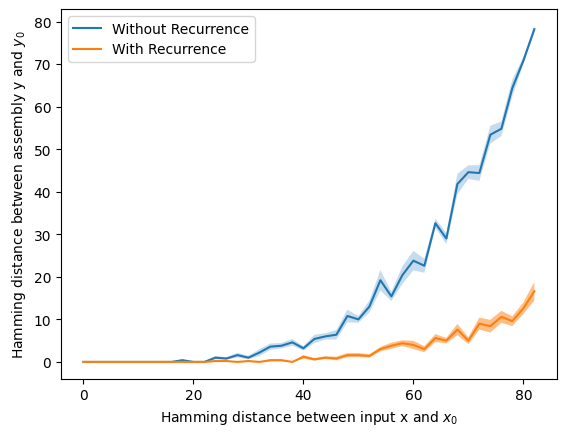

In [ ]:
for x, y, sem, re in zip(size_in, size_out, size_sem, rec):
  if re == False:
    plt.plot(x,y,label='Without Recurrence')
    plt.fill_between(x, y - sem, y +
                         sem, alpha=0.25)
    print('without re', [(i,j) for i, j in zip(x,y)])
  else:
    plt.plot(x,y,label='With Recurrence')
    plt.fill_between(x, y - sem, y +
                         sem, alpha=0.5)
    print('with rec', [(i,j) for i, j in zip(x,y)])

# plt.title("Analysis of Ham(x,x_0) and Ham(y,y_0) under %i training steps and %i recovery steps with/without Recurrence"%(proj_time, recover_time))
plt.xlabel('Hamming distance between input x and $x_{0}$')
plt.ylabel('Hamming distance between assembly y and $y_{0}$')
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend(loc='upper left')

# Save the plot
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/gdrive')
# images_dir = '/content/gdrive/My Drive/images'

# plt.savefig(f"{images_dir}/assem_recall.pdf")
# files.download("/content/gdrive/My Drive/images/assem_recall.pdf")

plt.show()

Note:
- seems like for any (noisy) input, you always recover the same assembly.
- assembly = "encoding concept/entity"
- when looking at a diff concept, the input neural activity should be entirely different (ie. ham = 80), but then the assembly still fires.

# **B) Assembly Recall: Keep Coreset and Change $p_r$ With A Class of Stimuli (using Akshay's distribution)** 

**Note on setup:** 
* $p$ =0.03, $\beta$ = 0.05, $T_{train}$ = 40, $T_{recover}$ = 10;
* We replicate for 10 trials per value on x-axis
* This should have the same procedure as the module above.

In [ ]:
def assembly_recall_stream_keep_coreset(recur, T_train, T_recover):
  B = 0.05
  n, k = 1000, 41
  p = 0.03
  coreset = np.random.permutation(n)[:k]
  x_coreset = np.zeros(n)
  x_coreset[coreset] = 1.0

  W_yx = np.random.binomial(1,p,size=(n,n)).astype("float64")
  W_yx_init = np.copy(W_yx)
  if recur:
    W_yy = np.random.binomial(1,p,size=(n,n)).astype("float64")
    W_yy_init = np.copy(W_yy)

  y_tm1 = np.zeros(n)
  
  # training
  for t in range(T_train):
      x = generate_stimulus(n, k, 0.9, coreset=coreset)

      if recur:
        y_t = W_yx.dot(x) + W_yy.dot(y_tm1)
        y_t = capk(y_t, k)

        # plasticity modifications
        W_yx = hebbian_update(W_yx, y_t, x, B)
        W_yy = hebbian_update(W_yy, y_t, y_tm1, B)
        
        y_tm1 = np.copy(y_t)

      else:
        y_t = W_yx.dot(x)
        y_t = capk(y_t, k)
            
        # plasticity modifications
        W_yx = hebbian_update(W_yx, y_t, x, B)
  
  # recovering under 10 trials; calculate HM(y,y_0) each trial then average out
  prs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  result = np.zeros((len(prs), 10))
  for j, pr in enumerate(prs):
    print("recovering for pr =", pr)
    per_pr = []
    for trial in tqdm(range(10)): 
      y_copy = copy.deepcopy(y_t)
      for t in range(T_recover):
        x = generate_stimulus(n, k, pr, coreset=coreset) #noisy stimuli
        if recur:
          y_tr = W_yx.dot(x) + W_yy.dot(y_copy)
          y_tr = capk(y_tr, k)
          y_copy = np.copy(y_tr)
        else:
          y_tr = W_yx.dot(x)
          y_tr = capk(y_tr, k)

        #calculate hamming distance at this step
      per_pr.append(hamming(y_tr,y_t)*n)
    result[j] = per_pr
    print()

  return np.mean(result, axis=1), np.std(result, axis=1)/np.sqrt(10)

In [ ]:
parameters = [True, False]
size, both_sem = []
prs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for para in parameters:
  total_support_size, sem = assembly_recall_stream_keep_coreset(para,40,10)
  size.append(total_support_size)
  both_sem.append(sem)

for r, arr, sem in zip(parameters, size, both_sem):
    if r: 
      plt.plot(prs,arr,label='With Recurrence')
      plt.fill_between(prs, arr - sem, arr +
                         sem, alpha=0.25)
    else:
      plt.plot(prs,arr,label='Without Recurrence')
      plt.fill_between(prs, arr - sem, arr +
                         sem, alpha=0.25)
plt.xlabel('Fraction of stimulus neurons drawn from coreset ($p_r$)')
plt.ylabel('Hamming distance between assemblies $y$ and $y_0$')
plt.autoscale(enable=True, axis='both', tight=None)
plt.legend(loc='upper left')

"""save file"""
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/gdrive')
# images_dir = '/content/gdrive/My Drive/images'
# plt.savefig(f"{images_dir}/pattern_comp_change_pr_same_coreset.pdf")
# files.download("/content/gdrive/My Drive/images/pattern_comp_change_pr_same_coreset.pdf")

plt.show()

# **C) Assembly Recall: Keep Same $p_r$ With A Coreset of Some Hamming Distance Away From the Original**

In [ ]:
def perturbate_coreset(ham_dis, coreset):
  output = copy.deepcopy(coreset)
  if ham_dis == 0:
    return output
  replace = list(np.random.permutation(len(coreset))[:ham_dis]) # elements for replacement
  flag = len(replace)
  while flag != 0:
    lucky_number = random.randrange(1000)
    if lucky_number not in coreset:
      replace_index = replace.pop()
      output[replace_index] = lucky_number
      flag -= 1
  return output

In [ ]:
# test case
coreset = np.random.permutation(40)[:10]
print(coreset)
print(perturbate_coreset(3, coreset))

[38 19 32 24 30  1  3  0 33 17]
[ 38 664 771  24  30   1   3   0  33 225]


In [ ]:
def assembly_recall_stream_keep_pr(recur, T_train, T_recover):
  B, n, k, p = 0.05, 1000, 41, 0.03
  coreset = np.random.permutation(n)[:k]
  x_coreset = np.zeros(n)
  x_coreset[coreset] = 1.0

  W_yx = np.random.binomial(1,p,size=(n,n)).astype("float64")
  W_yx_init = np.copy(W_yx)

  if recur:
    W_yy = np.random.binomial(1,p,size=(n,n)).astype("float64")
    W_yy_init = np.copy(W_yy)

  y_tm1 = np.zeros(n)
  
  # training
  for t in range(T_train):
      x = generate_stimulus(n, k, 0.9, coreset=coreset)

      if recur:
        y_t = W_yx.dot(x) + W_yy.dot(y_tm1)
        y_t = capk(y_t, k)

        # plasticity modifications
        W_yx = hebbian_update(W_yx, y_t, x, B)
        W_yy = hebbian_update(W_yy, y_t, y_tm1, B)
        y_tm1 = np.copy(y_t)

      else:
        y_t = W_yx.dot(x)
        y_t = capk(y_t, k)
            
        # plasticity modifications
        W_yx = hebbian_update(W_yx, y_t, x, B)
  
  # recovering under 10 trials; calculate HM(y,y_0) each trial then average out
  ham_range = np.linspace(0, 2*k, 8).astype(int)
  result = np.zeros((len(ham_range), 10))
  for j, ham in enumerate(ham_range):
    print("recovering for ham", ham)
    per_ham = []
    for trial in tqdm(range(10)):  
      y_copy = copy.deepcopy(y_t)
      for t in range(T_recover):
        # change coreset here
        x = generate_stimulus(n, k, 0.9, coreset=perturbate_coreset(ham, coreset)) #noisy stimuli
        if recur:
          y_tr = W_yx.dot(x) + W_yy.dot(y_copy)
          y_tr = capk(y_tr, k)
          y_copy = np.copy(y_tr)
        else:
          y_tr = W_yx.dot(x)
          y_tr = capk(y_tr, k)

        #calculate hamming distance at this step
      per_ham.append(hamming(y_tr,y_t)*n)
    result[j] = per_ham

  # return output
  return np.mean(result, axis=1), np.std(result, axis=1)/np.sqrt(10)

In [ ]:
parameters = [True, False]
size, both_sem = [], []
ham_range = np.linspace(0, 2*41, 8).astype(int)
for para in parameters:
  total_support_size, sem = assembly_recall_stream_keep_pr(para,100,50)
  size.append(total_support_size)
  both_sem.append(sem)

for r, arr, sem in zip(parameters, size, both_sem):
    if r: 
      plt.plot(ham_range, arr,label='With Recurrence')
      plt.fill_between(ham_range, arr - sem, arr +
                         sem, alpha=0.25)
    else:
      plt.plot(ham_range, arr,label='Without Recurrence')
      plt.fill_between(ham_range, arr - sem, arr +
                         sem, alpha=0.25)
plt.xlabel('Hamming distance between coresets')
plt.ylabel('Hamming distance between assemblies $y$ and $y_0$')
plt.autoscale(enable=True, axis='both', tight=None)
plt.legend(loc='upper left')

"""save plot"""
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/gdrive')
# images_dir = '/content/gdrive/My Drive/images'
# plt.savefig(f"{images_dir}/assem_recall_same_pr_diff_coreset.pdf")
# files.download("/content/gdrive/My Drive/images/assem_recall_same_pr_diff_coreset.pdf")

plt.show()